In [1]:
import nilearn

In [2]:
from nilearn import datasets
atlas = datasets.fetch_atlas_msdl()
# Loading atlas image stored in 'maps'
atlas_filename = atlas['maps']
# Loading atlas data stored in 'labels'
labels = atlas['labels']

In [3]:
import pandas

In [12]:
subj_idx = '001'

In [13]:
import os

In [14]:
import nibabel as nb
atlas_im = nb.load(atlas_filename)

In [15]:
path = os.path.join(os.environ['HOME'], 'data/openfmri/ds164/derivatives/fmriprep/sub-{subj_idx}/func/sub-{subj_idx}_task-stroop'.format(**locals()))

data = path + '_bold_space-MNI152NLin2009cAsym_preproc.nii.gz'.format(run)

confounds = path + '_bold_confounds.tsv'.format(run)

confounds = pandas.read_csv(confounds, sep='\t', na_values='n/a').fillna(method='bfill')

from nilearn.input_data import NiftiMapsMasker
masker = NiftiMapsMasker(maps_img=atlas_im, standardize=True, memory='nilearn_cache')

time_series = masker.fit_transform(data, confounds=confounds.values)

In [16]:
import matplotlib.pyplot as plt

In [17]:
%matplotlib inline

(0, 100)

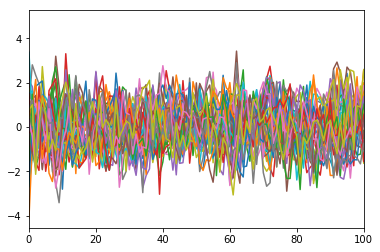

In [18]:
_ = plt.plot(time_series)
plt.xlim(0, 100)

In [19]:
# This code makes a connectivity matrix using a set of timeseries
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([time_series])[0]

In [20]:
def plot_correlation_matrix(correlation_matrix):
    # Display the correlation matrix
    import numpy as np
    from matplotlib import pyplot as plt
    plt.figure(figsize=(10, 10))
    # Mask out the major diagonal
    np.fill_diagonal(correlation_matrix, 0)
    plt.imshow(correlation_matrix, interpolation="nearest", cmap="RdBu_r",
               vmax=0.9, vmin=-0.9)
    plt.colorbar()
    # And display the labels
    x_ticks = plt.xticks(range(len(labels)), labels, rotation=90)
    y_ticks = plt.yticks(range(len(labels)), labels)

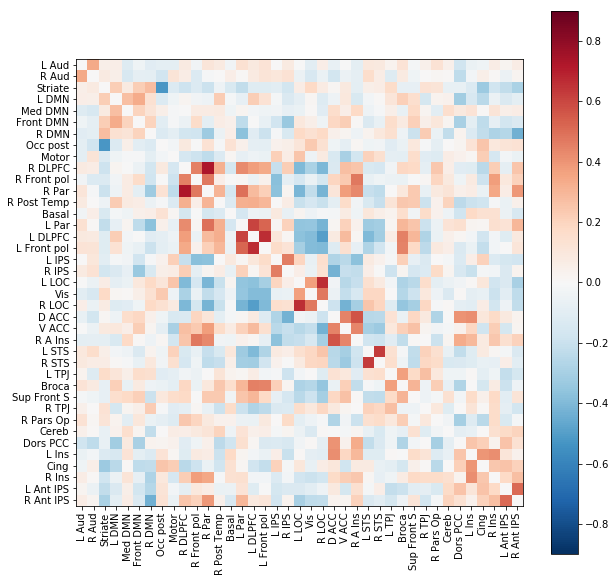

In [21]:
# Here we plot it
plot_correlation_matrix(correlation_matrix)

In [22]:

from nilearn import plotting
import numpy as np


In [23]:
coords_connectome = [plotting.find_xyz_cut_coords(img) for img in nilearn.image.iter_img(atlas_im)]

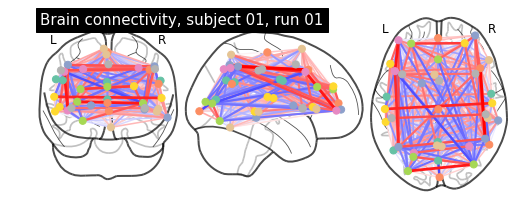

In [24]:
plotting.plot_connectome(correlation_matrix, coords_connectome, title='Brain connectivity, subject 01, run 01')

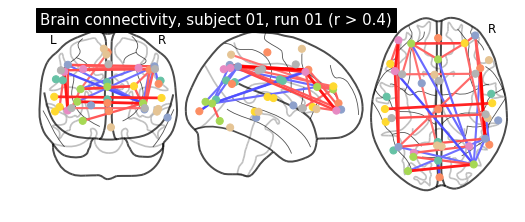

In [25]:
correlation_matrix = np.ma.masked_array(correlation_matrix, np.abs(correlation_matrix) < 0.4)
plotting.plot_connectome(correlation_matrix, coords_connectome, title='Brain connectivity, subject 01, run 01 (r > 0.4)')

In [26]:
import matplotlib.pyplot as plt

In [28]:
subjects = ['%03d' % i for i in range(1, 29)]

Working on subject 001
Working on subject 002


/Users/gilles/anaconda3/envs/py27/lib/python2.7/site-packages/nilearn/input_data/base_masker.py:98: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_maps_masker_extractor'
  memory_level=memory_level)(imgs)


Working on subject 003
Working on subject 004
Working on subject 005
Working on subject 006
Working on subject 007
Working on subject 008
Working on subject 009
Working on subject 010
Working on subject 011
Working on subject 012
Working on subject 013
Working on subject 014
Working on subject 015
Working on subject 016
Working on subject 017
Working on subject 018
Working on subject 019
Working on subject 020
Working on subject 021


/Users/gilles/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Working on subject 022
Working on subject 023
Working on subject 024
Working on subject 025
Working on subject 026
Working on subject 027
Working on subject 028


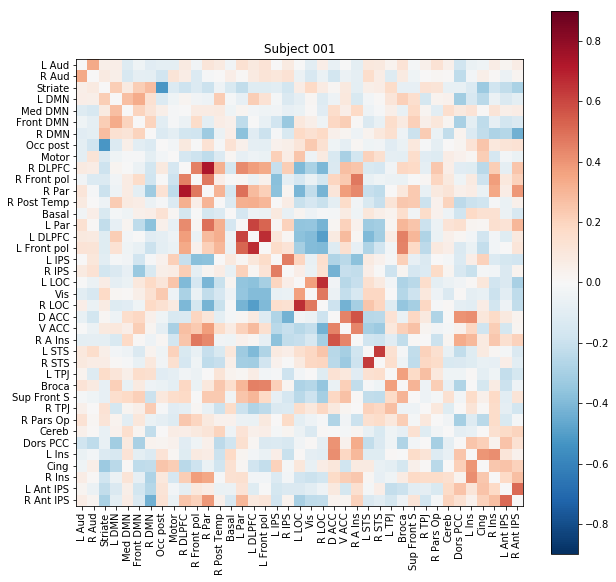

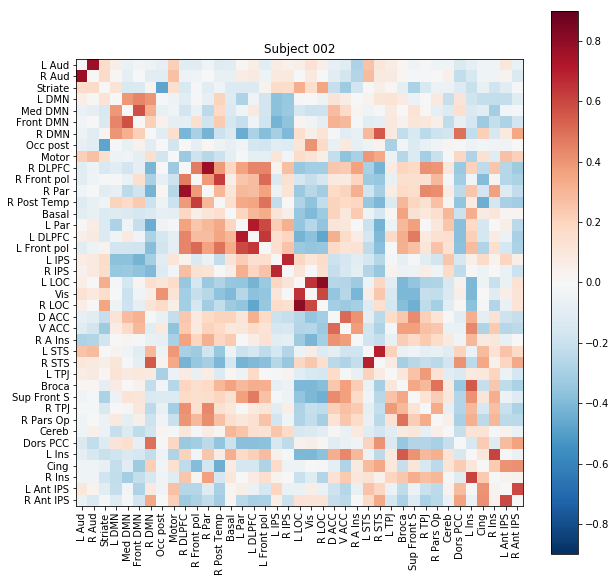

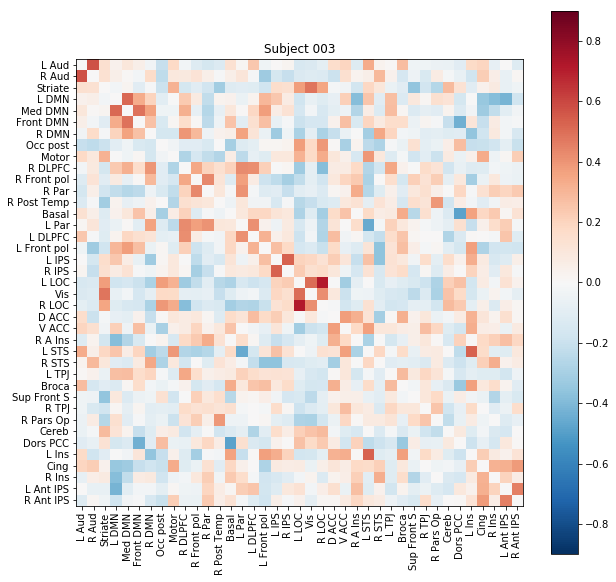

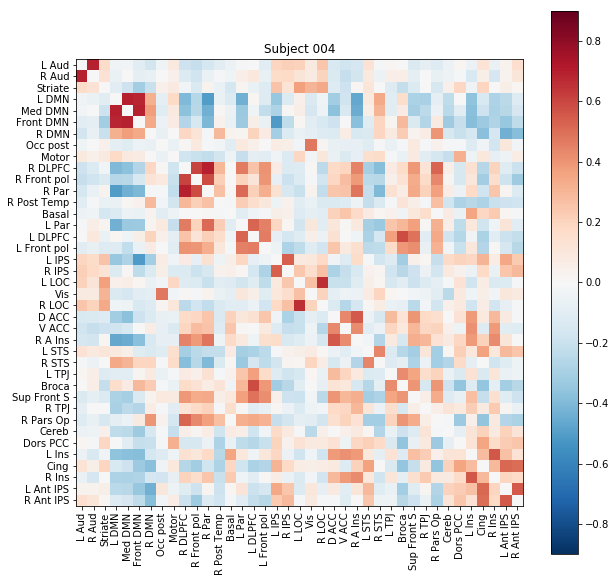

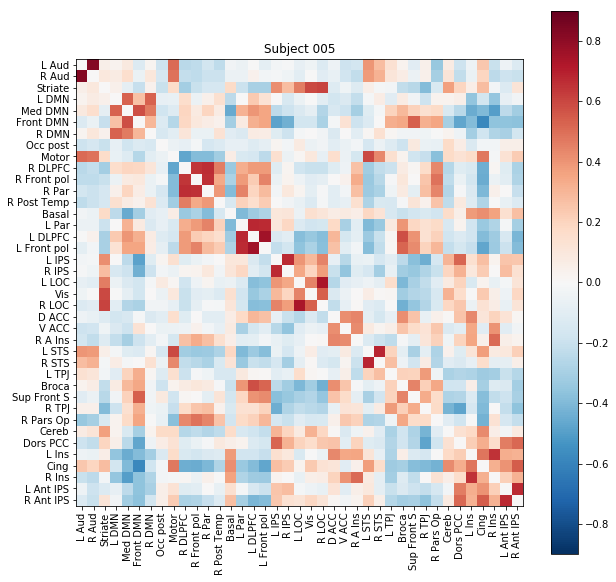

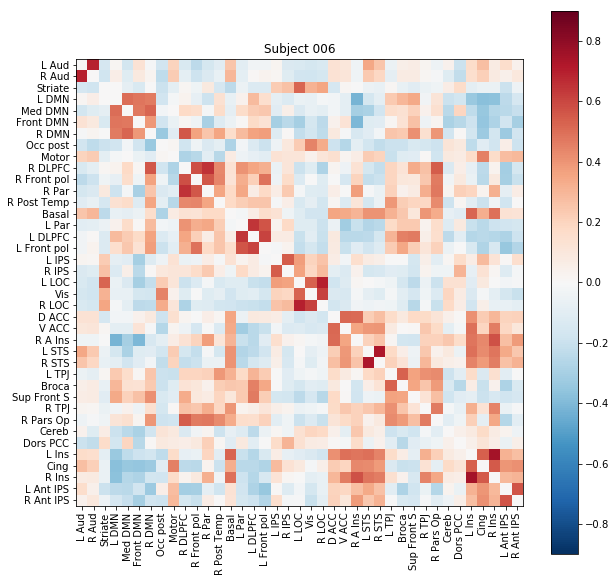

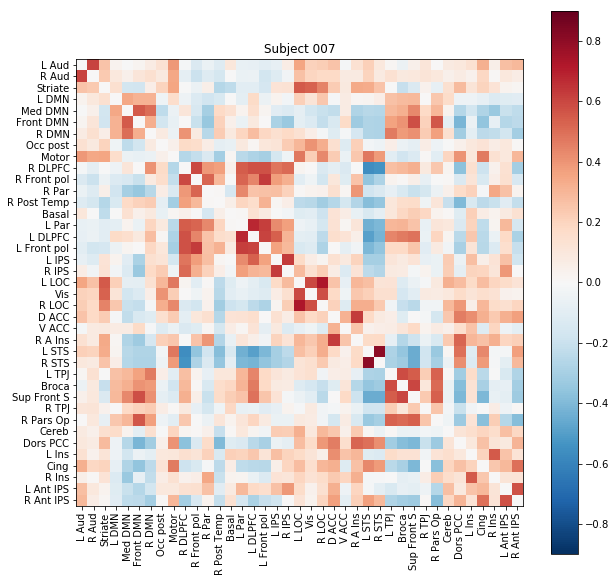

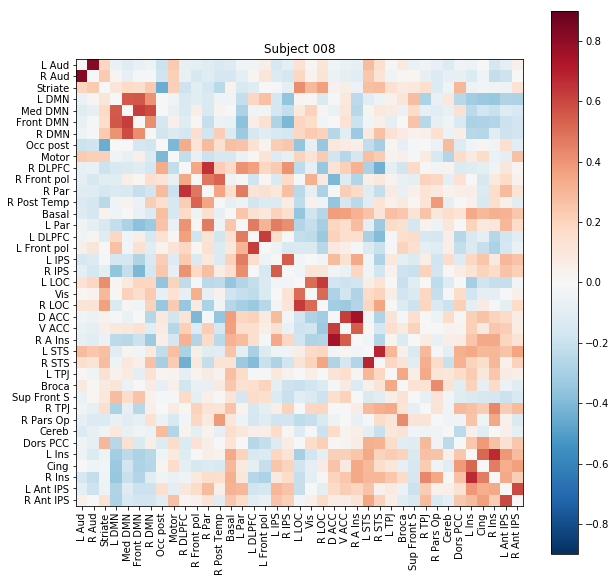

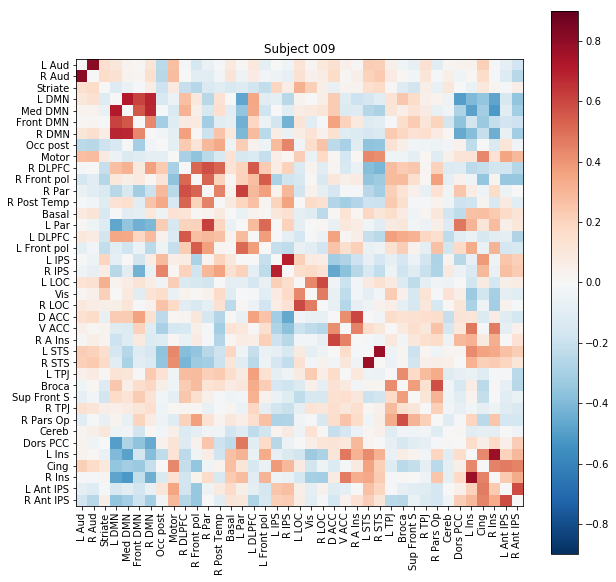

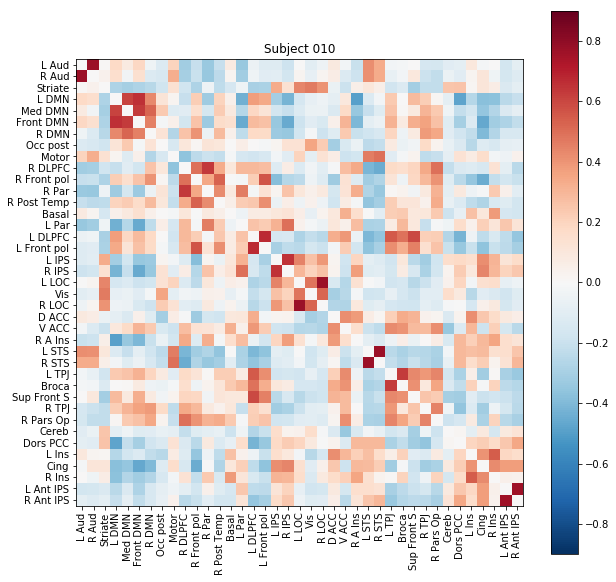

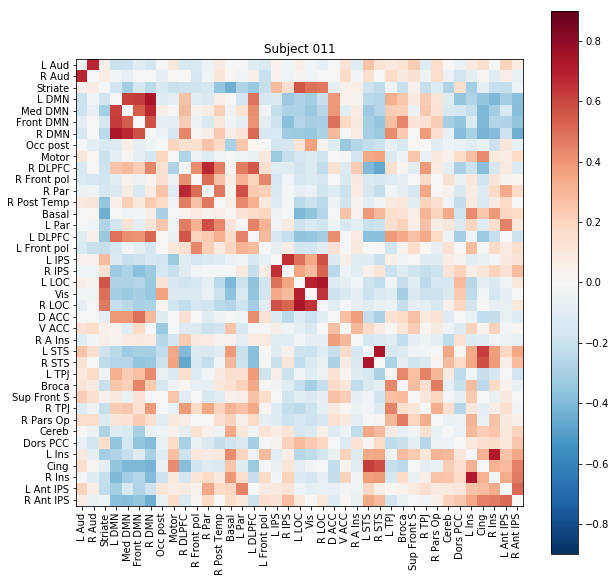

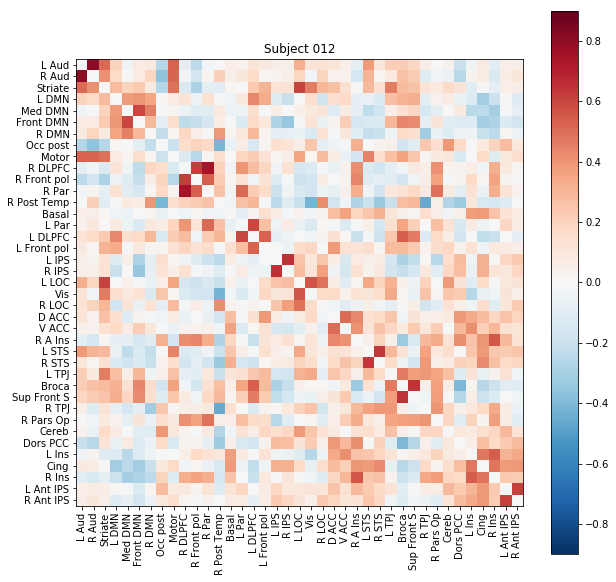

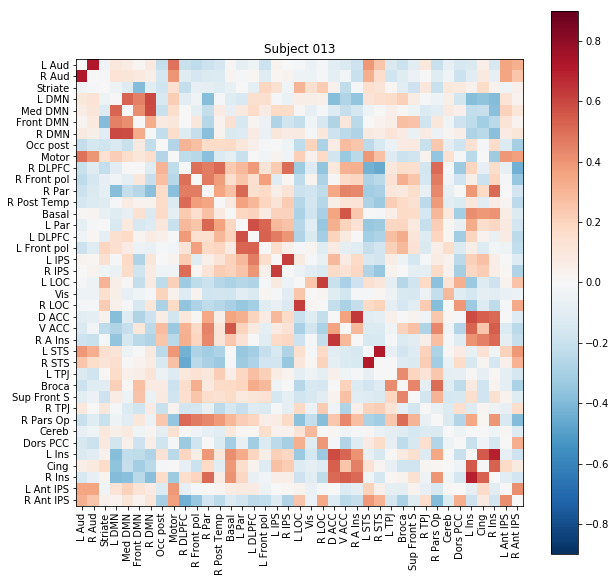

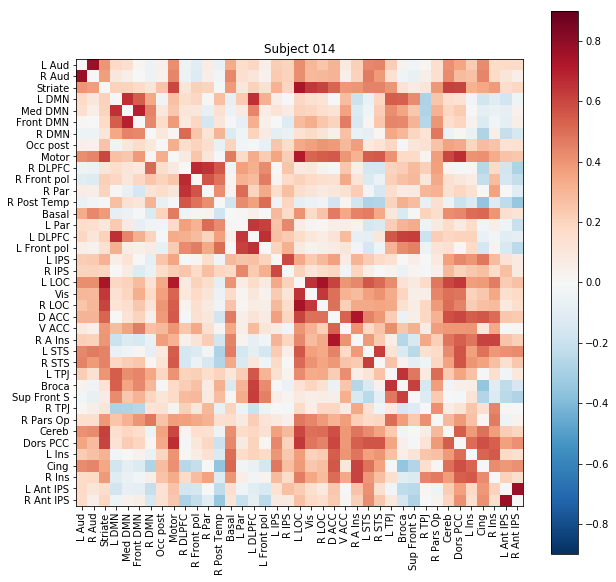

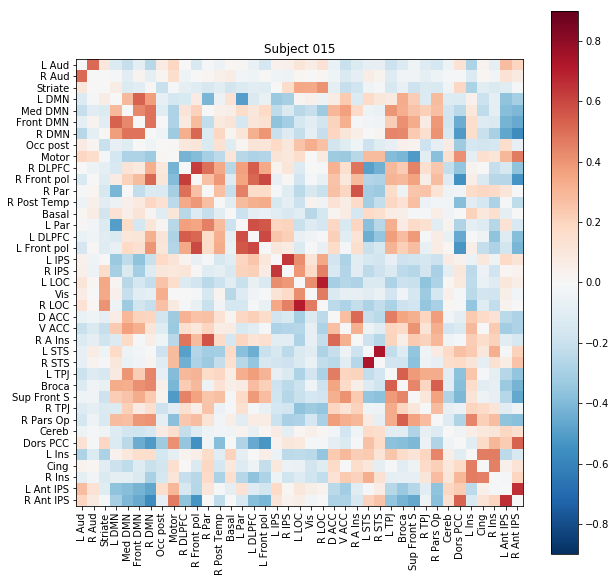

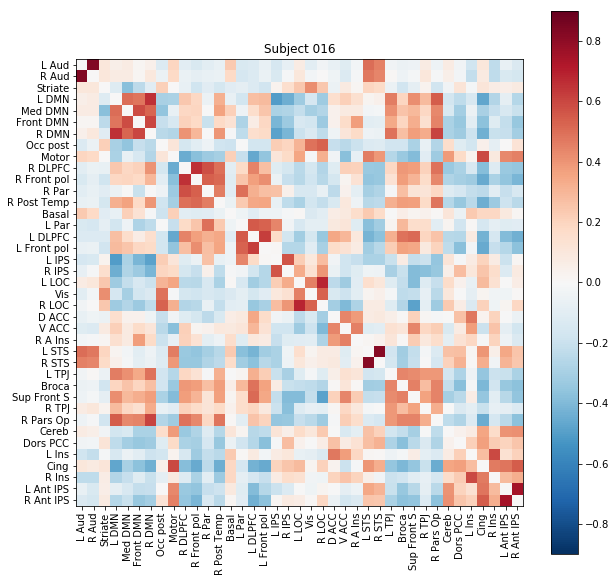

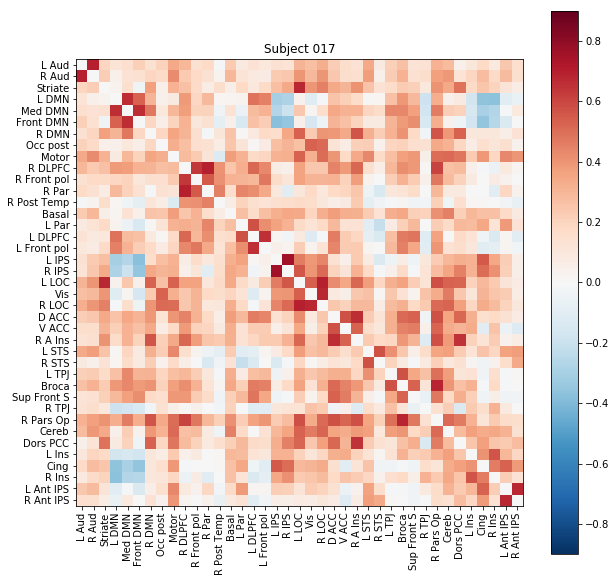

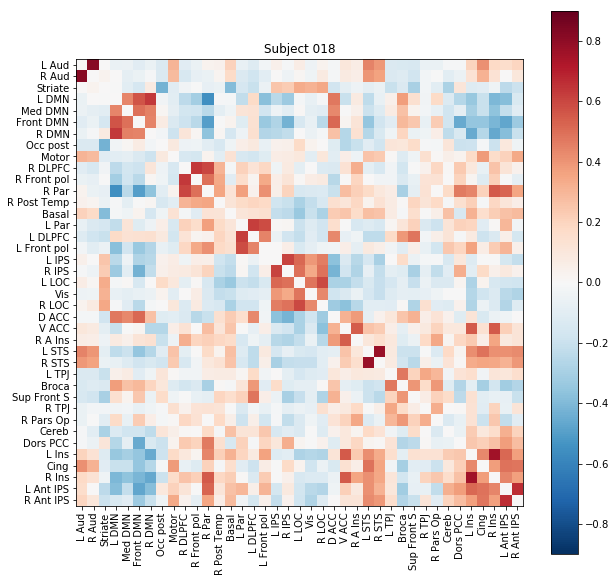

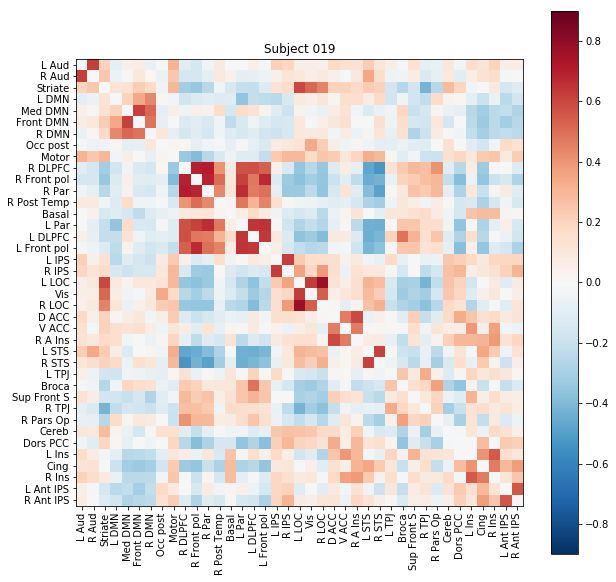

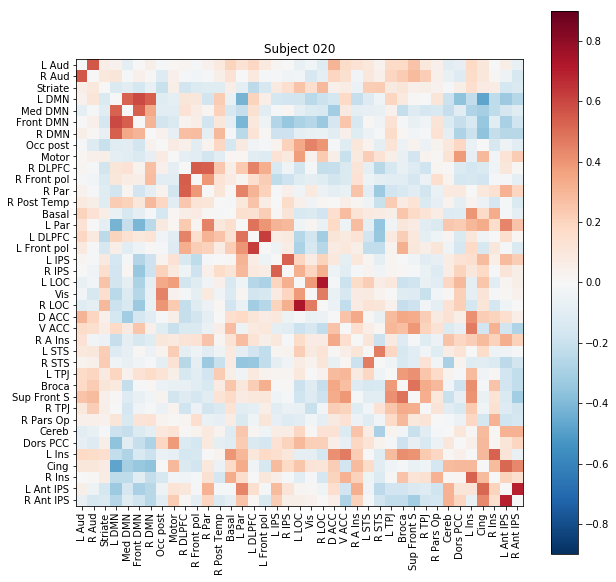

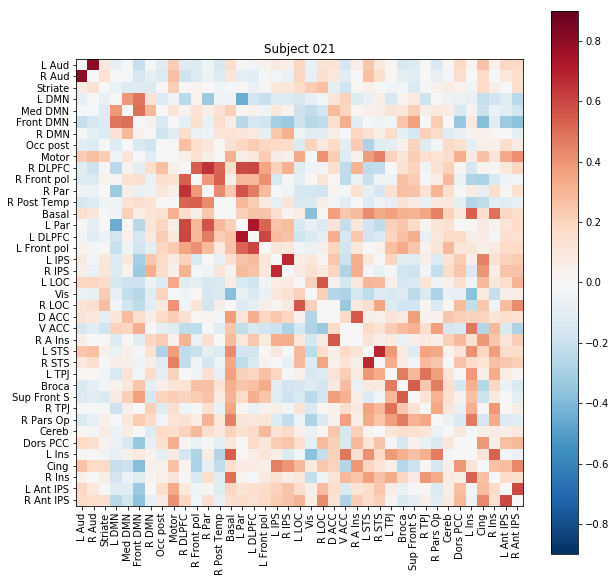

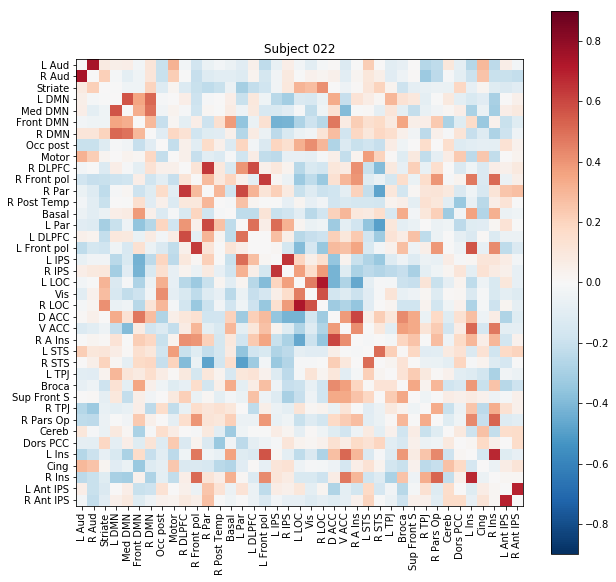

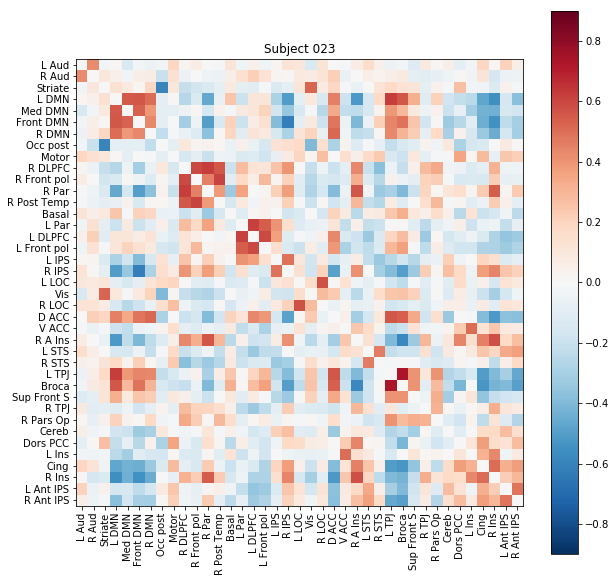

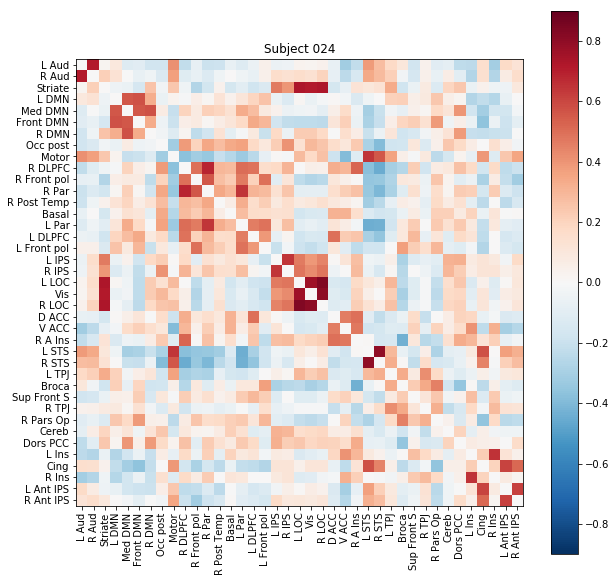

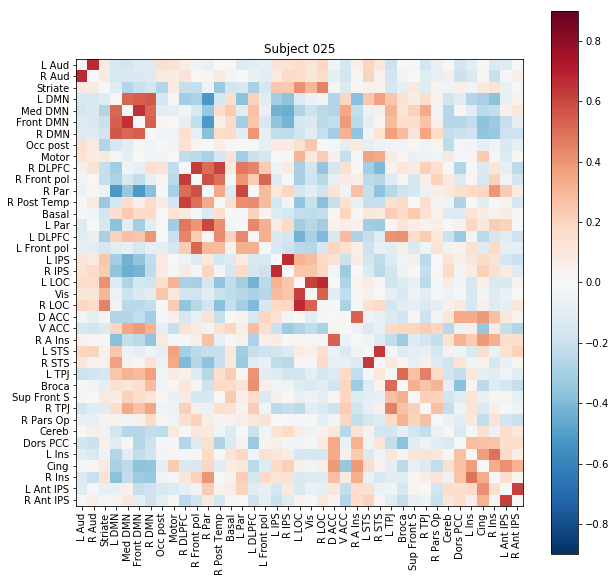

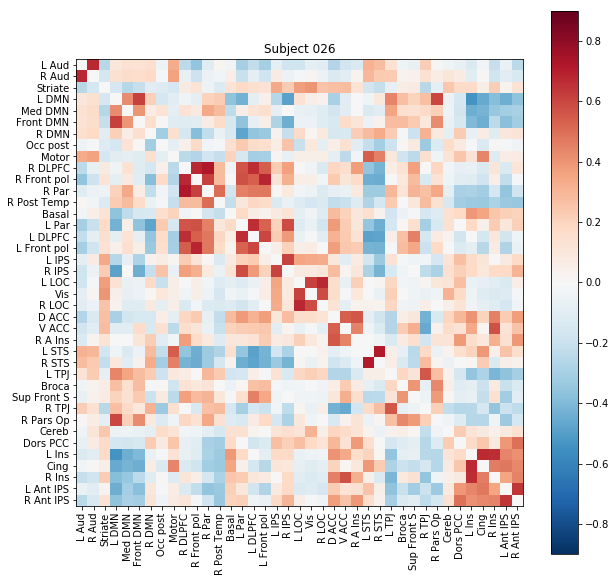

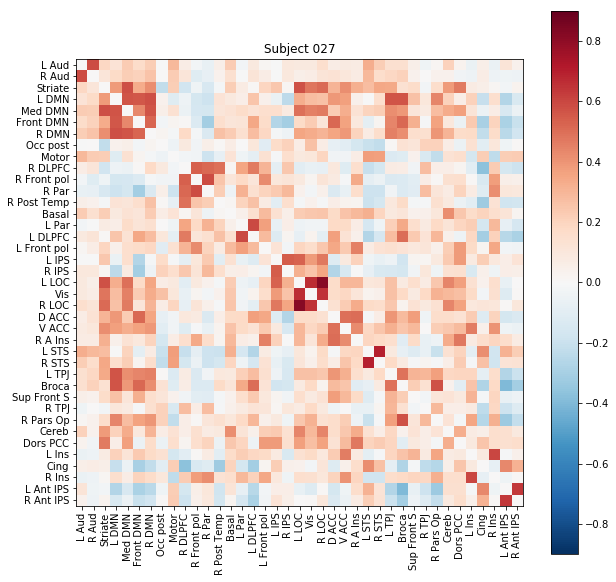

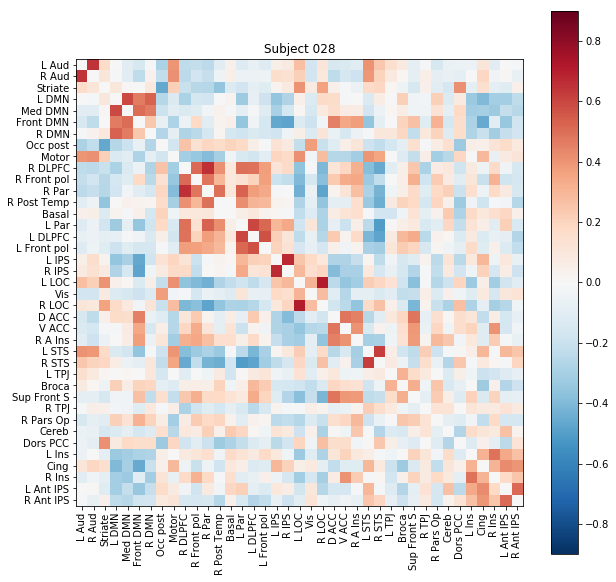

In [30]:
# Make a masker
masker = NiftiMapsMasker(maps_img=atlas_im, standardize=True, memory='nilearn_cache', memory_level=5)

# Make a list to fill up with correlation matrices
correlation_matrices = []


# Loop over 26 subjects
for subj_idx in subjects:
    
    print('Working on subject {}'.format(subj_idx))
    timeseries = []
    

    path = os.path.join(os.environ['HOME'], 'data/openfmri/ds164/derivatives/fmriprep/sub-{subj_idx}/func/sub-{subj_idx}_task-stroop'.format(**locals()))

    data = path + '_bold_space-MNI152NLin2009cAsym_preproc.nii.gz'.format(run)

    confounds = path + '_bold_confounds.tsv'.format(run)

    confounds = pandas.read_csv(confounds, sep='\t', na_values='n/a').fillna(method='bfill')


    # Extract timeseries for every mask in the atlas
    ts = masker.fit_transform(data, confounds=confounds.values)
    timeseries.append(ts)
    
    
    # Create a correlation matrix for the two 
    correlation_measure = ConnectivityMeasure(kind='correlation')
    correlation_matrix = np.mean(correlation_measure.fit_transform(timeseries), 0)
    plot_correlation_matrix(correlation_matrix)
    plt.title('Subject {}'.format(subj_idx))
    
    correlation_matrices.append(correlation_matrix)

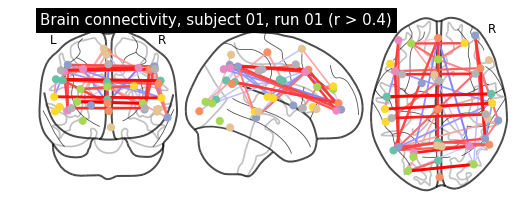

In [31]:
correlation_matrix = np.ma.masked_array(np.mean(correlation_matrices, 0), np.abs(correlation_matrix) < 0.4)
plotting.plot_connectome(correlation_matrix, coords_connectome, title='Brain connectivity, subject 01, run 01 (r > 0.4)')

In [32]:
!ls

1) Behavior.ipynb            nilearn_cache
2) GLM.ipynb                 start_point_diff.nii.gz
3) connectivity matrix.ipynb stroop.csv
drift_difference.nii.gz      stroop_z.csv
inc_congruent.nii.gz


In [36]:
import pandas
v_diff = pandas.read_csv('stroop.csv')

v_diff = v_diff.pivot_table(index='subj_idx', columns='tag', values='mean')

In [37]:
import scipy as sp
from scipy import stats

In [38]:
def correlation_across_connectivity_matrics(y, X):
    n = X.shape[1]

    X = X.reshape((X.shape[0], -1))
    Xm = X.mean(0)
    ym = y.mean()

    r_num = ((X-Xm)*y[:, np.newaxis]).sum(0)
    r_den = np.sqrt(np.sum((X-Xm)**2,axis=0)*np.sum((y-ym)**2))
    
    r = r_num/r_den
    r = r.reshape((n, n))

    dof = X.shape[0] - 2

    t = (r * np.sqrt(dof)) / np.sqrt(1- r**2)

    p = 2 * sp.stats.t(dof).sf(t)
    
    return r, p

In [42]:
diffs = (v_diff['congruent'] - v_diff['incongruent']).values

In [43]:
correlation_matrices = np.array(correlation_matrices)

In [87]:
r, p = correlation_across_connectivity_matrics(diffs, correlation_matrices)

/Users/gilles/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in divide
  # This is added back by InteractiveShellApp.init_path()


In [99]:
sns.set_style('white')

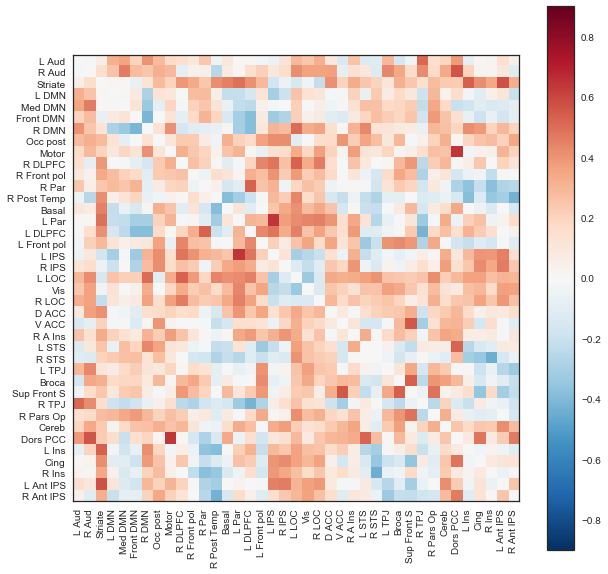

In [100]:
plot_correlation_matrix(r)

/Users/gilles/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


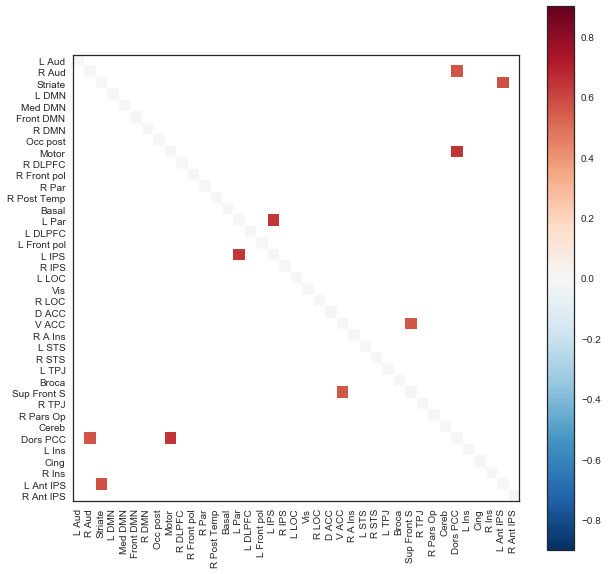

In [101]:
plot_correlation_matrix(np.ma.masked_array(r, p > 0.0025))

/Users/gilles/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


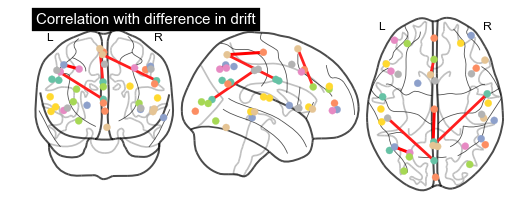

In [102]:
plotting.plot_connectome(np.ma.masked_array(r, p > 0.0025), coords_connectome, title='Correlation with difference in drift', )

In [103]:
import statsmodels
from statsmodels.sandbox.stats import multicomp

In [104]:
import seaborn as sns

In [105]:
ps = np.tril(p, -1)
sig, p_, _, _ = multicomp.multipletests(ps[ps!=0], method='fdr_bh')

In [106]:
sig.sum()

0

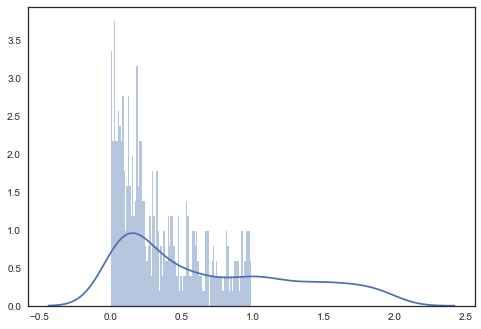

In [107]:
sns.distplot(p[~np.isnan(p)], bins=np.arange(0, 1, 0.01))